In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import time
from network import *
from utility import *
import simpy
import logging

In [2]:
logger= None

In [3]:
#Create and configure logger 
def initiate_logging ():
    logging.basicConfig(filename="newfile.log", 
                        format='%(asctime)s %(message)s', 
                        filemode='w') 

    #Creating an object 
    logger=logging.getLogger() 

    #Setting the threshold of logger to DEBUG 
    logger.setLevel(logging.DEBUG) 
    return logger

In [4]:
%matplotlib notebook
plt.ion()

In [5]:
#FILES FOR INPUT
STATIONS_FILENAME = 'deadlock_stations.txt'
RAILWAY_FILENAME = 'deadlock_railway.txt'
TRAINS_FILENAME = 'deadlock_train.txt'

#GLOBAL VARIABLES
TOTAL_SIMULATION_TIME = 15
CURRENT_SIMULATION_TIME = 0

#TRAINS NEEDING ACTION
TRAINS_NEEDING_ACTION = []                 #A list containing trains that need action at the given simulation time

In [6]:
env = simpy.Environment()

In [7]:
N = Network(STATIONS_FILENAME, RAILWAY_FILENAME , env)

In [8]:
#Creating the train class
class Train:
    id_ = 0
    def __init__ (self  , name , avg_speed , priority , route  , env , network):
        '''
        @parameters 
        name         : name of the train
        avg_speed    : average speed of the train
        priority     : priority of the train, later will be used in the algorithm
        route        : a python list of touple that gives the stations on the route along with the expected time 
                       of departure
        env          : Simpy environment where simulation is done
        network      : network on which the train is running 
        
        TODO
        ____________________________________
        
        Notes :
        1. Time is just an integer for now. It can change in the future.
        2. Simmulation starts at time 0. So the time in the route should always be greater than 0
        3. We assume that the arrival and departure time of the trains are the same for each station in the route.
           However in the log it is possible to have the arrival and departure time different.
        4. self.current : gives the name of the station or the track train is currently using
        '''
        #Global variables
        global TRAINS_NEEDING_ACTION
        
        #initialise the variables
        self.__class__.id_ += 1
        self.id = self.__class__.id_
        self.name = name
        self.speed = avg_speed
        self.priority = priority
        self.route = route
        self.env = env              
        self.network = network

        #for the current status of the train
        self.running = False                        #True if the train is running                        
        self.station_or_not = False                 #True if standing on station
        self.current = '_'                          #Current station name or the track (tuple)
        self.current_index = -1                     #upto which point the route is travelled
        self.current_track = -1                     #current track number on the particular station or track  
        self.done = False                           #indicate wether the journey is complete or not
        
        #resource that the train is acquiring currently
        self.resource = None   
        self.request = None
        
        #for storing the log
        self.log = [(d , -1 , -1) for d,t in route]          #(station_name , arrival , departure)
        
        #resource that the train is waiting for
        self.waiting = '-'                         #name of the station or track : train is waiting for
        
    def compute_time (self , distance):
        '''
        returns the time needed to travel the distance  
        @paramters :
        distance : to be travelled
        
        '''
        return distance/self.speed
    
            
    def move_train (self , env):
        '''
        ONLY FOR SIMULATION
        This function runs the train
        This function is only used for simulation purpose
        It will start the whole train and then finishes the journey
        '''
        #Create the relevant processes
        initiate_train_proc = env.process (self.initiate_train(self.env))
        yield initiate_train_proc

        while self.done == False:
            move_train_one_step_proc = env.process (self.move_train_one_step(env))
            yield move_train_one_step_proc
            
        
        finish_journey_process = env.process (self.finish_journey(self.env))
        yield finish_journey_process
                
        
    def act (self , env , action):
        '''
        Depending on the action given the train will either move or stop
        Only two actions are there : move or stop
        move:
             If the train is not yet started then put it on the track
             If train is running then move one step
             If train has completed the journey but not freed resource then free it.
             If train has completed the journey and freed resource then do nothing.
        wait:
            wait for 1 unit time
        '''
        
        assert action in ['move' , 'wait']
        
        if action == 'move':
            
            #Train is not yet started
            if (self.done == False and self.running == False):
                initiate_train_proc = env.process (self.initiate_train(self.env))
                yield initiate_train_proc
                
                #Put the train in line for taking action at a particular time
                TRAINS_NEEDING_ACTION.append(self.name)
                
            #Train is running
            elif (self.running == True):
                move_train_one_step_proc = env.process (self.move_train_one_step(env))
                yield move_train_one_step_proc
                
                TRAINS_NEEDING_ACTION.append(self.name)
            
            #train has completed the journey but the resource is not freed
            elif (self.done == True and self.resource is not None):
                finish_journey_process = env.process (self.finish_journey(self.env))
                yield finish_journey_process
        
                #Since the journey is complete no need of taking further action
            else:
                logger.warning('Time : {} -- Train {} has completed the journey'.format(env.now , self.name))
        
            
        #wait for one unit time
        else:
            
            #Warning if train has completed the journey
            if (self.done == True and self.resource is None):
                logger.warning('Time : {} -- Train {} has completed the journey'.format(env.now , self.name))
            
            #Wait for 1 minute
            wait_train_proc = env.process(self.wait_train(self.env))
            yield wait_train_proc
            
            #Put the train in the list
            TRAINS_NEEDING_ACTION.append(self.name)

        
    
    
    def initiate_train (self , env):
        '''
        This function puts the train on the track
        This function is initialised as the process in the __init__ function
        @parameters
        env : simpy environment
        '''
        logger.info("Time : {} -- Train {} initiating".format(env.now, self.name) )
        start_station , start_time = self.route[0]
        
        #wait till the right time comes to be on train
        wait = max (0 , start_time - env.now)
        yield env.timeout(wait)
        
        
        #try to acquire the resource related to the station
        #It may be possible that the station is all full and the train cannot be put there.
        #In that case, we have to wait to put train on the station
        resource = self.network.get_station_resource (start_station)
        request = resource.request()
        
        #put in the waiting list
        self.waiting = start_station
        yield request                            #wait for the station to be free
        #out of waiting list
        self.waiting = '-'
        self.resource = resource                 
        self.request = request
        
        #acuire the station
        self.current_track = self.network.lock_station (start_station , self.name)
        
        #update the current status
        self.current_index = 0 
        self.current = start_station
        self.station_or_not = True
        self.running = True
        
        #update the log
        self.log[self.current_index] = (start_station , env.now , -1)
        
        logger.info("Time : {} -- Train {} initiated.".format(env.now , self.name) )
        

            
        
    def wait_train (self, env):
        '''
        This function waits for one unit time
        '''
        logger.info("Time : {} -- Train {} Wait for 1 unit time".format(env.now , self.name))
        yield env.timeout(0)
        
    def move_train_one_step (self, env):
        '''
        Move the train
        This function does not move the train before the tentative time table
        If already reached destination then returns -1
        '''
        #if the train is not running return -1
        if (self.running == False):
            return -1
        
        
        #If the train is on the station and ready to depart
        if (self.station_or_not):
             
            '''
            Since the train is on the station
                  - If already reached the final station then return -1
                  - if not, then leave the station track and try to acuire the next track in between the stations
                  
            '''
            
            #if the train has completed the journey
            if (self.done):
                return -1

            
            current_station , depart_time = self.route[self.current_index]
            next_station , dest_time = self.route[self.current_index + 1]
            current_time = env.now
            track = self.network.G[current_station][next_station]['details']
            logger.info("Time : {} -- Train {} Try to depart to track {}-{}".format( env.now, self.name ,
                                                                              current_station , next_station) )
            #wait If reached the station before the depart time
            wait = max(0 , depart_time - current_time)
            yield env.timeout (wait)
            
            #now try to acquire the track in between the station
            resource = self.network.get_track_resource (current_station , next_station)
            request = resource.request()
            
            self.waiting = (current_station , next_station)
            yield request
            self.waiting = '-'
            
            prev_track = self.current_track
            self.current_track = self.network.lock_track(current_station , next_station , self.name)
            
            #release the current resource
            self.resource.release(self.request)
            self.network.free_station(current_station , prev_track)
            self.resource =  resource
            self.request = request
            
            logger.info("Time : {} -- Train {} On track {}-{}".format( env.now , self.name , 
                                                                              current_station , next_station) )
            #update the log ; depart time
            self.log[self.current_index] = (self.log[self.current_index][0] , self.log[self.current_index][1] ,  env.now) 
        
            #update the current_status 
            self.current = (current_station , next_station) 
            self.station_or_not = False                       #on the track
            
            #travel down the track
            len_of_track = track.length_of_tracks[self.current_track]
            time_to_travel = self.compute_time(len_of_track)
            yield env.timeout (time_to_travel)
            
            logger.info("Time : {} -- Train {} Travelled on track {}-{}".format(env.now , self.name ,
                                                                              current_station , next_station) )
            
        else:
            '''
            Train has travelled down the track and waiting to arrive to the station
            '''
            #we are moving from station_x to station_y 
            station_x , station_y  = self.current
            logger.info("Time : {} -- Train {} Try to arrive at station {}".format( env.now ,self.name , 
                                                                              station_y ) )
            #try to acquire the track on the next station
            resource = self.network.get_station_resource(station_y)
            request = resource.request()
            #put in wait list
            self.waiting = station_y
            #request for resource
            yield request
            #out of wait list
            self.waiting = '-'
            prev_track = self.current_track
            self.current_track = self.network.lock_station (station_y , self.name)
            
            #release the current resource
            self.resource.release(self.request)
            self.network.free_track (station_x , station_y , prev_track)
            self.resource = resource
            self.request = request
            
            logger.info("Time : {} -- Train {} Arrived at station {}".format(env.now , self.name ,
                                                                              station_y ) )
            self.current = station_y
            self.station_or_not = True
            self.current_index += 1
            
            #arrival time
            self.log[self.current_index] = (self.log[self.current_index][0] , env.now ,  -1 ) 
            
            #if completed the journey
            if (self.current_index == len(self.route) - 1):
                logger.info("Time : {} -- Train {} Completed journey.".format(env.now ,self.name ) )
                self.done = True
                self.running = False
                
        return 0
                
    def finish_journey (self , env):
        '''
        This function is used when the train finishes it's journey.
        Note : Instead of releasing the resource immediately, wait for the arrival time at the station
            and then free the resource
        '''
        if (self.done == True):
            
            #Wait for the arrival time at the station
            station , arrive_time = self.route[self.current_index]
            wait_time = max(0 , arrive_time - env.now)
            yield env.timeout(wait_time)
            
            #update the log : correct depart time
            self.log[self.current_index] = (self.log[self.current_index][0] , self.log[self.current_index][1] ,  env.now) 
            
            
            #release all the resource
            self.resource.release(self.request)
            self.network.free_station(self.route[-1][0] , self.current_track)
            
            #update the status of the train
            self.current = '_'                          
            self.current_index = -1                     #upto which point the route is travelled
            self.current_track = -1                     #current track number on the particular station or track  
            
            #not acquiring any resource
            self.resource = None
            self.request = None

            #logging 
            logger.info("Time : {} -- Train :{} Completed Journey : Released all the resources ".format(env.now , self.name)) 
        
    def print_details (self):
        '''
        Prints all the information of the train
        '''
        print(50 * '*')
        print("Train ID : {}".format(self.id_))
        print("Name :{}".format(self.name))
        print("Priority : {}".format(self.priority))
        print("Average speed : {}".format(self.speed))
        
        print("Route of the train")
        for d,t in self.route:
            print("            {} : {} ".format(d , t))

        #print the waiting
        if not self.waiting == '-':
            if (type(self.waiting) == str):
                print("Waiting for {}".format(self.waiting))
            else:
                print("Waiting for {} - {}".format(self.waiting[0] , self.waiting[1]))
                
        #train not yet started
        if (self.running== False and self.done == False):
            print("Train not yet started")
        #Train is currently running
        elif (self.running):
            print("Train is running")
            if (self.station_or_not):
                print("Currently at station {}".format(self.current))
            else:
                print("Currently on track {}-{}".format(self.current[0] , self.current[1]))
        
        #train has reached final station but had not left the final station
        elif (self.done == True and self.resource is not None):
            print('Train reached the destination : about to leave the station')
            
        #train completed the journey
        else:
            print("Train has completed the journey")
            print ("______Printing log________")
            for d, t_a , t_d in self.log:
                print("            {} : {} {} ".format(d , t_a , t_d))
                
        print(50 * '*')
        
            

In [9]:
#utility function
def update_graph (env , interval):
    '''
    This function will simulate the whole process on a GUI
    This function is going to be used as the process
    @parameters
    env : simpy environment
    total_time : total time for the simulation
    '''
    fig = plt.figure(figsize = (8 , 8))
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    
    while True:
        #Draw graph
        
        N.draw_railway_network(ax  = ax , suppress_station_info= False , 
                               suppress_track_info= False , suppress_edge_label=False)

        #yield interval time
        yield env.timeout(interval)
        time.sleep(0.5)
        
        #log info
        logger.info("Time : {} Updating Graph".format(env.now))
        plt.title("Time {}".format(env.now))
        
        #Paint the canvas
        fig.canvas.draw()

In [10]:
def read_trains(filename):
    
    '''
    Reads the trains and put them in the list from the given filename
    '''
    trains = []
    with open(filename) as f:
        
        while True:
            line = f.readline().strip().split()
            
            if len(line) == 4:
                name , speed , priority, route_len = line[0] , int(line[1]) , int(line[2]) , int(line[3])

                route = []
                for _ in range(route_len):
                    line = f.readline().strip().split()
                    route.append((line[0] , int(line[1])))

                train = Train (name , speed , priority , route , env , N)
                trains.append(train)
            else:
                break
    return trains
        

In [11]:
def run_simulation (trains , total_time):
    
    '''
    Takes the train and total_time for simulation and run it    
    '''
    for t in trains:
        proc = env.process(t.move_train(env))

    sim_proc = env.process(update_graph(env , 1))
    env.run(until = 80)

In [12]:
trains = read_trains(TRAINS_FILENAME)

In [13]:
name_train_map = {}                #Map from train name to train object; note key can be changed to train_id 
for t in trains:
    name_train_map[t.name] = t

In [14]:
for t in trains:
    t.print_details()

**************************************************
Train ID : 2
Name :Train1
Priority : 1
Average speed : 1
Route of the train
            Zeta : 1 
            Beta : 2 
Train not yet started
**************************************************
**************************************************
Train ID : 2
Name :Train2
Priority : 1
Average speed : 1
Route of the train
            Beta : 1 
            Zeta : 2 
Train not yet started
**************************************************


In [15]:
logger = initiate_logging()

In [16]:
for t in trains:
    proc = env.process(t.act(env , 'move'))
sim_proc = env.process(update_graph(env , 1))

<IPython.core.display.Javascript object>


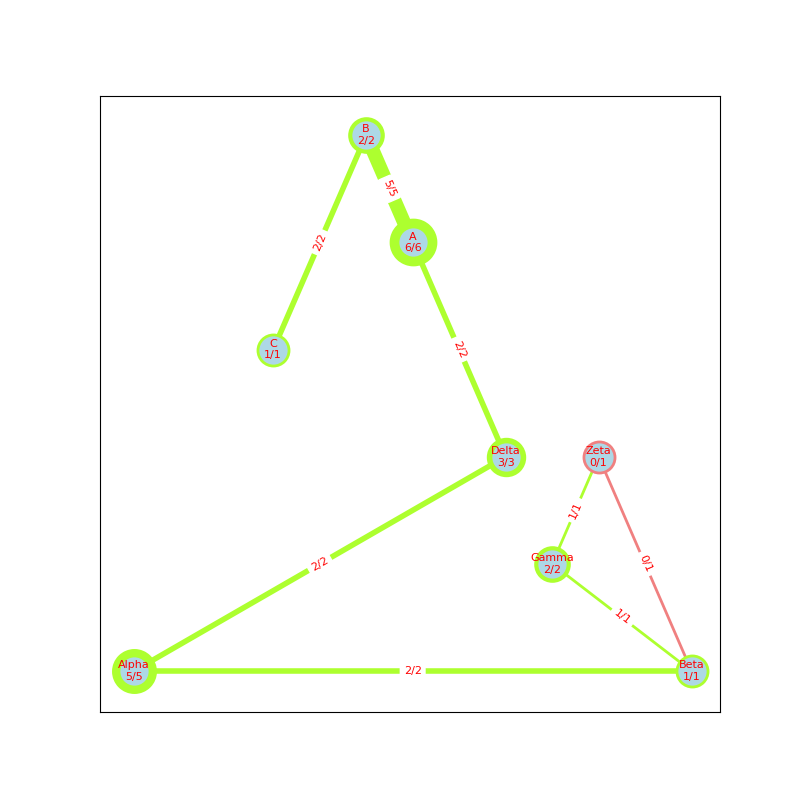

In [17]:
for _ in range(TOTAL_SIMULATION_TIME):
    CURRENT_SIMULATION_TIME += 1
    
    #free the trains needing action
    TRAINS_NEEDING_ACTION = []
    
    #Run the simulation
    env.run(until = CURRENT_SIMULATION_TIME)
    
    #Process the action for the trains in the list    
    #randomly take action for each train waiting for action 
    #We can also order the train for which we are taking the action depending on the situation
    actions = ['move' , 'wait']
    for name in TRAINS_NEEDING_ACTION:
        t = name_train_map[name]
        
        action = np.random.choice(actions , 1 , p = [0.5 , 0.5])          #move with 80% probability
        
        #Take the action
        env.process(t.act(env , action))
    
#     print(CURRENT_SIMULATION_TIME  , end = ' ')
#     print(TRAINS_NEEDING_ACTION)
    

In [18]:
# run_simulation(trains, 80)

In [19]:
for t in trains:
    t.print_details()

**************************************************
Train ID : 2
Name :Train1
Priority : 1
Average speed : 1
Route of the train
            Zeta : 1 
            Beta : 2 
Waiting for Zeta - Beta
Train is running
Currently at station Zeta
**************************************************
**************************************************
Train ID : 2
Name :Train2
Priority : 1
Average speed : 1
Route of the train
            Beta : 1 
            Zeta : 2 
Waiting for Zeta
Train is running
Currently on track Beta-Zeta
**************************************************


In [20]:
G,train_nodes , station_nodes , track_nodes = create_resource_usage_graph(trains , N)

<IPython.core.display.Javascript object>


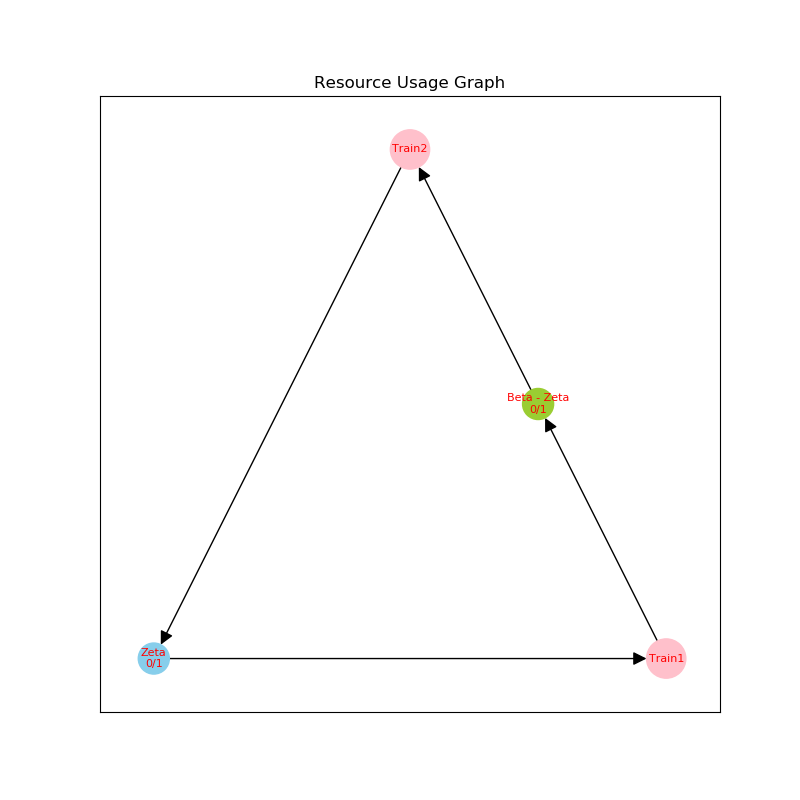

In [21]:
fig = plt.figure(figsize = (8 , 8))
ax = fig.add_subplot(111)
draw_network_usage_graph(G,train_nodes , station_nodes , track_nodes, N,ax)

In [22]:
# TODO
'''
1. Create a simple train class with all the parameters                                                Done
2. Implement the resource facility with the track and the station                                     Done
3. Run the single train on the track (without getting worried wether the resource is free or not)     Done  
4. Simulate whole thing on graph (single train only)                                                  Done
5. Run multiple instances of the train without worrying about the deadlock                            Done
   Create action for each train                                                                       Done
6. Try to simulate as you want to do in the project i.e. take action from the user.                   Done
   Also able to order the train for which to take the action at a particular time 
   
   
   
7. Try to create deadlock with the trains                                                             Done 
8. Create the graph for resource usage.                                                             Amost Done  
9. Use the standard deadlock detection algorithm for the detection of the algorithm                    -- 
   Implement the Bank's algorithm for deadlock detection.
'''

"\n1. Create a simple train class with all the parameters                                                Done\n2. Implement the resource facility with the track and the station                                     Done\n3. Run the single train on the track (without getting worried wether the resource is free or not)     Done  \n4. Simulate whole thing on graph (single train only)                                                  Done\n5. Run multiple instances of the train without worrying about the deadlock                            Done\n   Create action for each train                                                                       Done\n6. Try to simulate as you want to do in the project i.e. take action from the user.                   Done\n   Also able to order the train for which to take the action at a particular time \n   \n   \n   \n7. Try to create deadlock with the trains                                                             Done \n8. Create the graph for resourc